## Detectiong Objects (on images) with OpenCV and YOLO v3 in Python

**References** 

* [Deep Learning based Object Detection using YOLOv3 with OpenCV](https://www.learnopencv.com/deep-learning-based-object-detection-using-yolov3-with-opencv-python-c/) 
* [YOLO Object Detection with OpenCV and Python](https://www.arunponnusamy.com/yolo-object-detection-opencv-python.html)

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib

print( "OpenCV version:", cv2.__version__)

Using matplotlib backend: Qt5Agg
OpenCV version: 3.4.3


**Test image**

In [2]:
image_path = "../data/dog-bike.jpg"

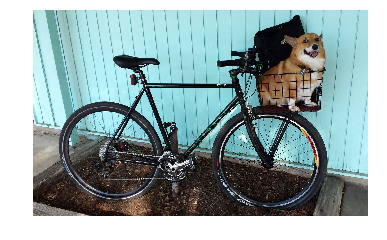

In [3]:
image = cv2.imread(image_path, cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)       
plt.axis('off')
plt.imshow( image )
plt.show()

In [4]:
img_height, img_width = image.shape[:2]

In [5]:
print( "Image dimensions:", img_width, img_height)

Image dimensions: 1600 982


**YOLO files**

The files used here were download from:
 * configuration file: https://github.com/pjreddie/darknet/blob/master/cfg/yolov3.cfg?raw=true
 * pre-trained weights file: https://pjreddie.com/media/files/yolov3.weights
 * text file containing class names: https://github.com/pjreddie/darknet/blob/master/data/coco.names?raw=true
 
You can use the method `filename = wget.download(url)` to downloand them.

In [6]:
# Path to yolo configuration file
model_configuration = "../yolo_files/yolov3.cfg"

# Path to yolo pre-trained weights
model_weights = "../yolo_files/yolov3.weights"

# Path to text file containing class names
classes_file = "../yolo_files/coco.names"

Read class names from text file

In [7]:
classes = None
with open(classes_file, "r") as f:
    classes = [line.strip() for line in f.readlines()]

In [8]:
print( classes[:5], "of", len(classes) )

['person', 'bicycle', 'car', 'motorbike', 'aeroplane'] of 80


Generate different colors for different classes 

In [9]:
colors = np.random.uniform( 0, 255, size = ( len(classes), 3 ) )

In [10]:
colors[:3]

array([[239.66699396, 208.87484194, 196.44406934],
       [  7.04791541, 140.04490047, 214.53507883],
       [253.85336211, 249.85110941, 144.54112508]])

Read pre-trained model and config file

In [11]:
net = cv2.dnn.readNetFromDarknet( model_configuration, model_weights)
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

Prepares the input image to run through the deep neural network. The input image to a neural network needs to be in a certain format called a **blob**.

In [12]:
inpWidth = 416       # Width of network's input image
inpHeight = 416      # Height of network's input image

scale = 1/255        # Scale factor for image normalization (0.00392)

In [13]:
blob = cv2.dnn.blobFromImage(image, scale, (inpWidth,inpHeight), (0,0,0), True, crop=False)
net.setInput(blob)

**Output layer and bounding box**

Generally in a sequential CNN network there will be only one output layer at the end. In the YOLO v3 architecture we are using there are multiple output layers giving out predictions. `get_output_layers()` function gives the names of the output layers. An output layer is not connected to any next layer.

In [14]:
# Function to get output layers names in the architecture
def get_output_layers( net ):
    layer_names = net.getLayerNames( )
    output_layers = [ layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers() ]
    return output_layers

In [15]:
get_output_layers( net )

['yolo_82', 'yolo_94', 'yolo_106']

`draw_bounding_box()` function draws rectangle over the given predicted region and writes class name over the box. If needed, we can write the confidence value too.

In [23]:
# Function to draw bounding box on the detected object with class name
def draw_bounding_box(img, class_id, confidence, x, y, x_plus_w, y_plus_h):
    label = str(classes[class_id])
    print( label, x, y, x_plus_w, y_plus_h )
    color = colors[class_id]
    cv2.rectangle(img, (x, y), (x_plus_w, y_plus_h), color, 2)
    cv2.putText(img, label, (x-10,y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    return img

**Running inference**

Run inference through the network and gather predictions from output layers

The line below is where the exact feed forward through the network happens. Moment of truth. If we don’t specify the output layer names, by default, it will return the predictions only from final output layer. Any intermediate output layer will be ignored.We need go through each detection from each output layer to get the class id, confidence and bounding box corners and more importantly ignore the weak detections (detections with low confidence value).

In [17]:
outputs = net.forward( get_output_layers(net) )

**Getting results**

Initialization

In [34]:
class_ids = []
confidences = []
bounding_boxes = []

conf_threshold = 0.5
nms_threshold = 0.4

For each detetion from each output layer get the confidence, class id, bounding box params and ignore weak detections (confidence < 0.5)

In [19]:
for out in outputs:
    
    for detection in out:
        
        scores = detection[5:]
        class_id = np.argmax( scores )
        conf = scores[ class_id ]
        
        if conf > conf_threshold:
            
            center_x = int(detection[0] * img_width)
            center_y = int(detection[1] * img_height)
            w = int(detection[2] * img_width)
            h = int(detection[3] * img_height)
            x = center_x - w / 2
            y = center_y - h / 2
            
            class_ids.append( class_id )
            confidences.append( float(conf) )
            bounding_boxes.append( [x, y, w, h] )

In [20]:
print( class_ids )
print( bounding_boxes )

[16, 1, 16]
[[1071.0, 85.5, 360, 407], [114.5, 135.0, 1311, 762], [1089.5, 103.5, 313, 373]]


**Visualizing results**

In [24]:
img_result = image.copy()
for class_id, conf, box in zip(class_ids, confidences, bounding_boxes):
    x, y, w, h = box
    img_result = draw_bounding_box( img_result, class_id, conf, round(x), round(y), round(x+w), round(y+h) )

dog 1071 86 1431 492
bicycle 114 135 1426 897
dog 1090 104 1402 476


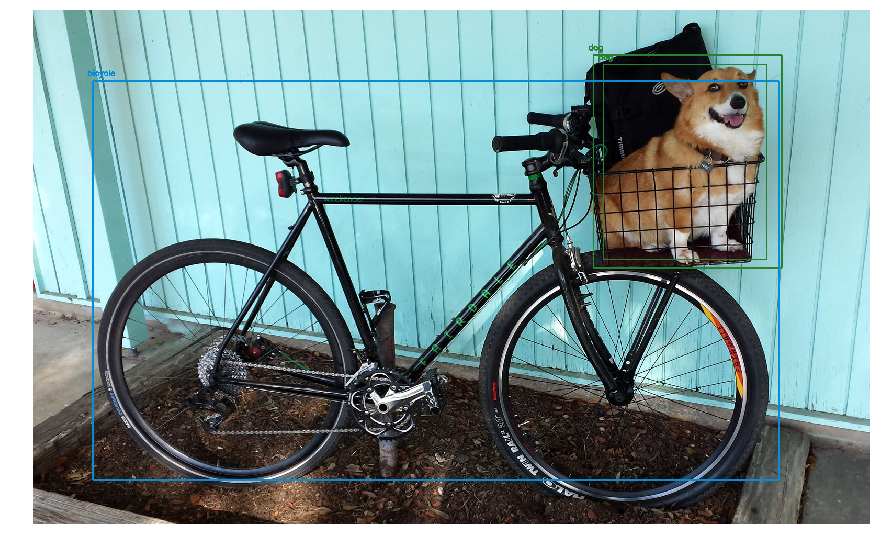

In [25]:
f = plt.figure(figsize=(15,15))
plt.axis('off')
plt.imshow( img_result )
plt.show()

**Applying non-max suppresion**

In [26]:
indices = cv2.dnn.NMSBoxes( bounding_boxes, confidences, conf_threshold, nms_threshold )

In [27]:
indices

array([[2],
       [1]], dtype=int32)

In [31]:
img_result_2 = image.copy()

for i in indices:
    i = i[0]
    x, y, w, h = bounding_boxes[i]
    img_result_2 = draw_bounding_box( img_result_2, class_ids[i], confidences[i], 
                                      round(x), round(y), round(x+w), round(y+h) )

dog 1090 104 1402 476
bicycle 114 135 1426 897


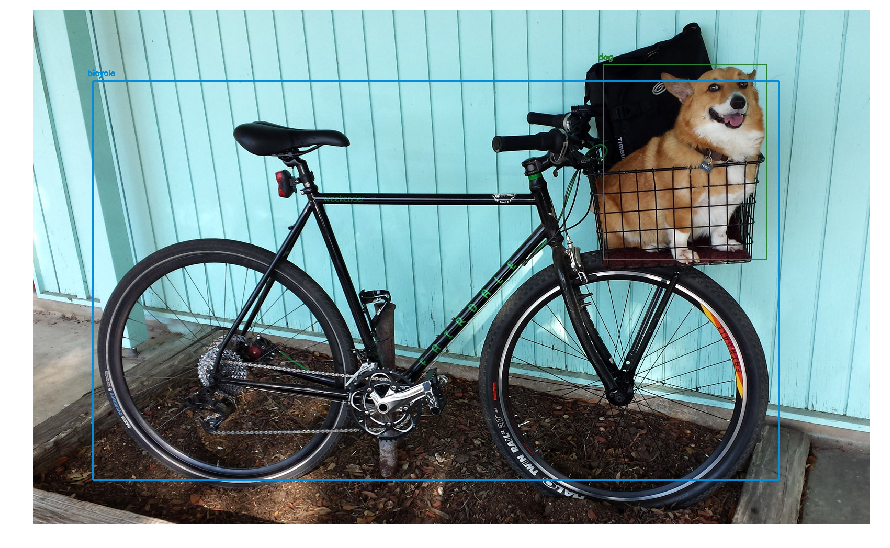

In [33]:
f = plt.figure(figsize=(15,15))
plt.axis('off')
plt.imshow( img_result_2 )
plt.show()